FIRST STEPS

In [1]:
from utils import *

# Load datasets
train_images_b, train_labels_b = load_dataset_split('data/original/balanced/train')
val_images_b, val_labels_b = load_dataset_split('data/original/balanced/val')
test_images_b, test_labels_b = load_dataset_split('data/original/balanced/test')

train_images_f, train_labels_f = load_dataset_split('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split('data/augmented/FracAtlas/test')

train_images = np.concatenate([train_images_b, train_images_f])
train_labels = np.concatenate([train_labels_b, train_labels_f])
test_images = np.concatenate([test_images_b, test_images_f])
test_labels = np.concatenate([test_labels_b, test_labels_f])
val_images = np.concatenate([val_images_b, val_images_f])
val_labels = np.concatenate([val_labels_b, val_labels_f])





In [2]:
# Create TensorFlow datasets (unchanged)
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [3]:
# Calculate class weights based on TRAINING SET
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_labels), 
                                   y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}


In [4]:
# Model definition (unchanged)
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

In [5]:
# Compile and train (unchanged)
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/50


320/320 [==============================] - 44s 120ms/step - loss: 0.3816 - accuracy: 0.8785 - precision: 0.9189 - recall: 0.8498 - auc: 0.9413 - val_loss: 2.3273 - val_accuracy: 0.4897 - val_precision: 1.0000 - val_recall: 0.0017 - val_auc: 0.6858 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 43s 136ms/step - loss: 0.4137 - accuracy: 0.8430 - precision: 0.9027 - recall: 0.7947 - auc: 0.9115 - val_loss: 1.4690 - val_accuracy: 0.5111 - val_precision: 0.7708 - val_recall: 0.0619 - val_auc: 0.6696 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 62s 193ms/step - loss: 0.4646 - accuracy: 0.8080 - precision: 0.8904 - recall: 0.7346 - auc: 0.8933 - val_loss: 2.8283 - val_accuracy: 0.4906 - val_precision: 1.0000 - val_recall: 0.0033 - val_auc: 0.6612 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 72s 226ms/step - loss: 0.4316 - accuracy: 0.8309 - precision: 0.8963 - recall: 0.7764 - auc: 0.9061 - val_loss: 1.2871 - val_ac

In [6]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

37/37 [==============================] - 1s 28ms/step - loss: 0.3117 - accuracy: 0.8810 - precision: 0.9005 - recall: 0.8762 - auc: 0.9505
Test Accuracy: 0.880993127822876
Test Precision: 0.9004893898963928
Test Recall: 0.8761904835700989
Test AUC: 0.9505133628845215


37/37 [==============================] - 1s 26ms/step


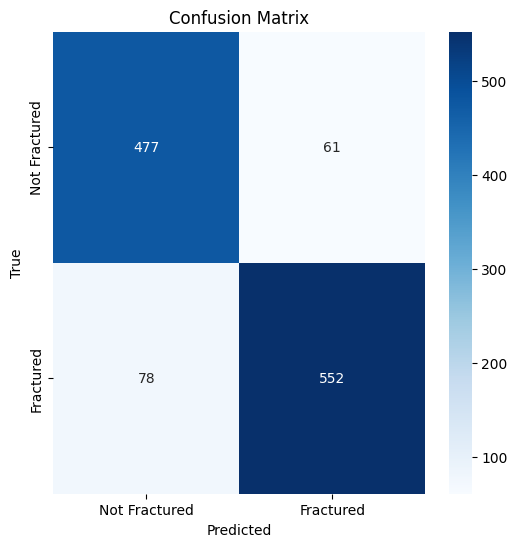

In [7]:
plot_conf_matrix(model, test_images, test_labels)

In [8]:
filename = 'binary_model_v3_augmented.pkl'
create_pkl(filename, model)

37/37 [==============================] - 1s 26ms/step


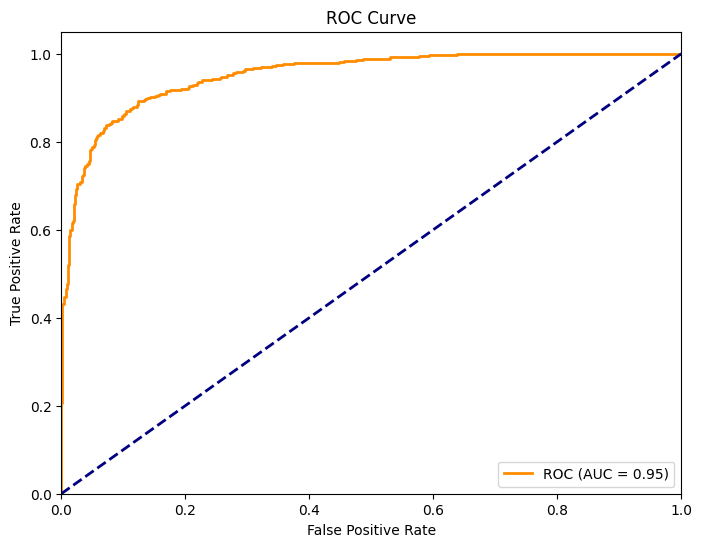

In [9]:
plot_roc_curve(model, test_images, test_labels)

37/37 [==============================] - 1s 27ms/step


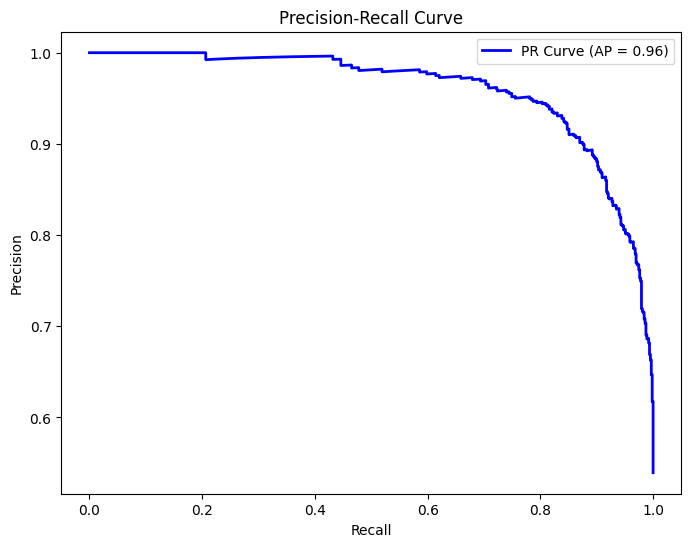

In [10]:
plot_pr_curve(model, test_images, test_labels)

37/37 [==============================] - 1s 26ms/step


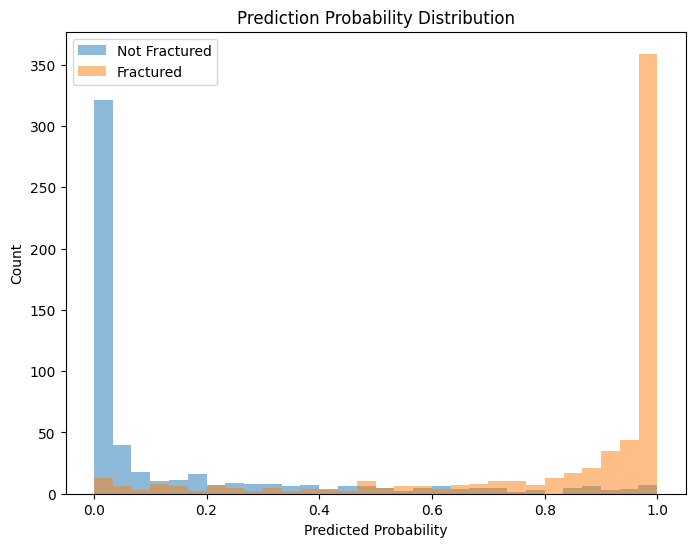

In [11]:
p_proba_dist(model, test_images, test_labels)

37/37 [==============================] - 1s 25ms/step


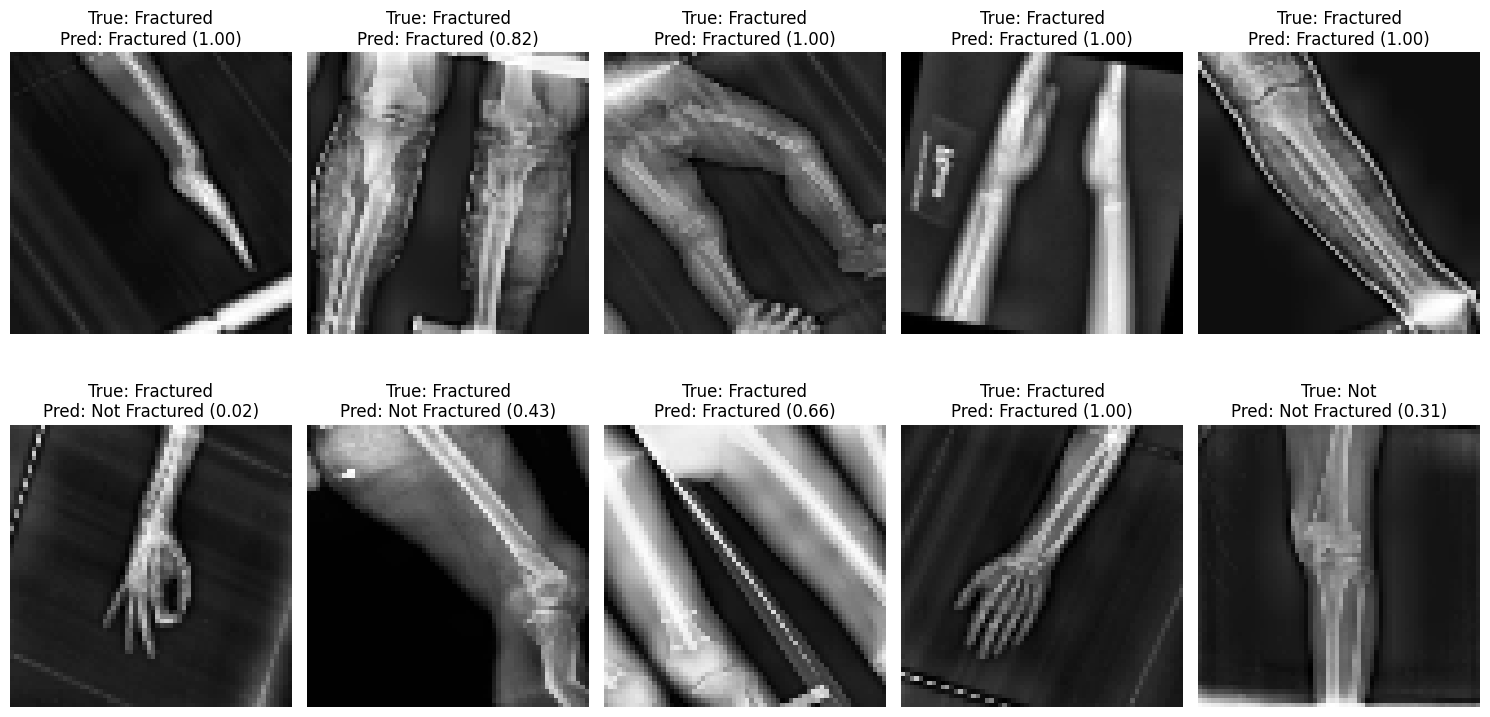

In [12]:
show_ten_samples(model, test_images, test_labels)

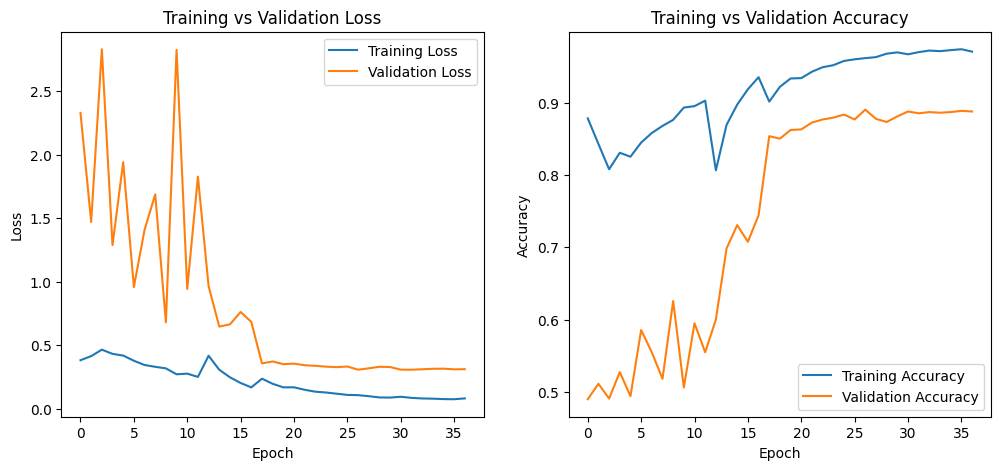

In [13]:
loss_accu_train(history)

Revisando las métricas, vamos a ajustar 8 epochs el modelo.